In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import utils
import warnings
warnings.simplefilter("ignore", category=RuntimeWarning)

# some resources for plotting
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.lines as mlines
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import utils as utils

print('xarray version ' + xr.__version__)
%matplotlib inline

xarray version 2023.1.0


In [2]:
path = '/glade/scratch/wwieder/MIMICS/'
case = ['exudate0','exudate2']
file = ['ann_mimics_pool_flux_1901_2014.nc','ann_casaclm_pool_flux_1901_2014.nc']

dirIn = [path+case[c]+'/'+file[f] for c in range(len(case)) for f in range(len(file))]
dirIn[0:2]


['/glade/scratch/wwieder/MIMICS/exudate0/ann_mimics_pool_flux_1901_2014.nc',
 '/glade/scratch/wwieder/MIMICS/exudate0/ann_casaclm_pool_flux_1901_2014.nc']

In [3]:
ds = xr.open_mfdataset(dirIn[0:2], decode_times=True, combine='by_coords',compat='override')
ds2 = xr.open_mfdataset(dirIn[2:4], decode_times=True, combine='by_coords',compat='override')
# sum pools with utils
ds = utils.sum_pools(ds,'mim',CN='True')
ds2 = utils.sum_pools(ds2,'mim',CN='True')
ds

<xarray.Dataset>
Dimensions:              (lon: 144, lat: 96, time: 114)
Coordinates:
  * lon                  (lon) float32 0.0 2.5 5.0 7.5 ... 352.5 355.0 357.5
  * lat                  (lat) float32 -90.0 -88.11 -86.21 ... 86.21 88.11 90.0
  * time                 (time) float32 1.902e+03 1.903e+03 ... 2.015e+03
Data variables: (12/86)
    day                  (time) int32 dask.array<chunksize=(114,), meta=np.ndarray>
    IGBP_PFT             (lat, lon) float64 dask.array<chunksize=(96, 144), meta=np.ndarray>
    landarea             (lat, lon) float32 dask.array<chunksize=(96, 144), meta=np.ndarray>
    cellMissing          (lat, lon) int32 dask.array<chunksize=(96, 144), meta=np.ndarray>
    cellid               (lat, lon) int32 dask.array<chunksize=(96, 144), meta=np.ndarray>
    cLITm                (time, lat, lon) float32 dask.array<chunksize=(114, 96, 144), meta=np.ndarray>
    ...                   ...
    cVEG                 (time, lat, lon) float32 dask.array<chunksize=(114, 96, 144), meta=np.ndarray>
    cECO                 (time, lat, lon) float32 dask.array<chunksize=(114, 96, 144), meta=np.ndarray>
    nVEG                 (time, lat, lon) float32 dask.array<chunksize=(114, 96, 144), meta=np.ndarray>
    nECO                 (time, lat, lon) float32 dask.array<chunksize=(114, 96, 144), meta=np.ndarray>
    cnVEG                (time, lat, lon) float32 dask.array<chunksize=(114, 96, 144), meta=np.ndarray>
    cnECO                (time, lat, lon) float32 dask.array<chunksize=(114, 96, 144), meta=np.ndarray>
Attributes:
    title:                     MIMICS model output
    comment:                   NOTE: None of the variables are weighted by la...
    history:                   Wed Mar  2 16:37:13 2022: ncrcat -O /project/t...
    source:                    MIMICS Model
    parameters:                ./pftlookup_LIDET-MIM-REV_CN_desorb2xKO4_micCN...
    NCO:                       netCDF Operators version 4.7.5 (Homepage = htt...
    nco_openmp_thread_number:  1

In [4]:
## Mask out low productivity grids
minNPP = 10/365 # npp given in gC/m2/d
initNPP = ds.cnpp.isel(time=slice(0,20)).mean(dim='time')
#print(initNPP)                            
ds = ds.where(initNPP>minNPP)
ds2 = ds2.where(initNPP>minNPP)


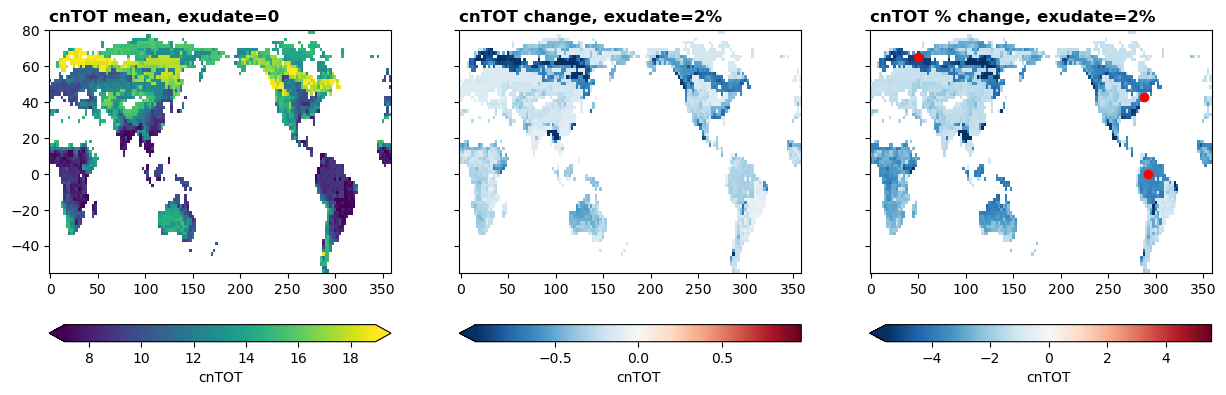

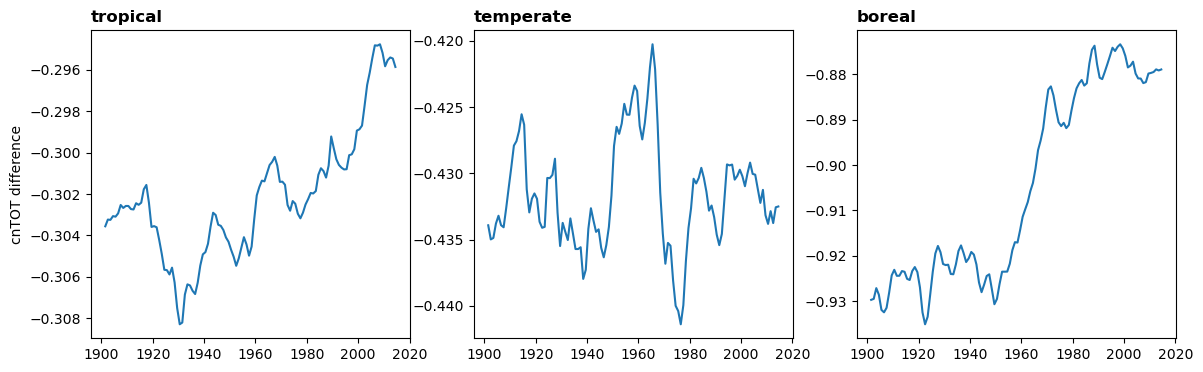

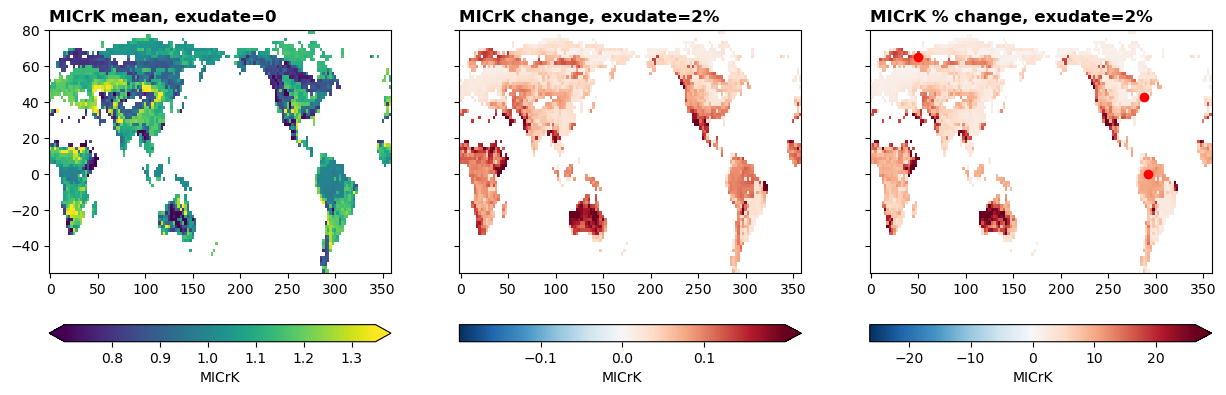

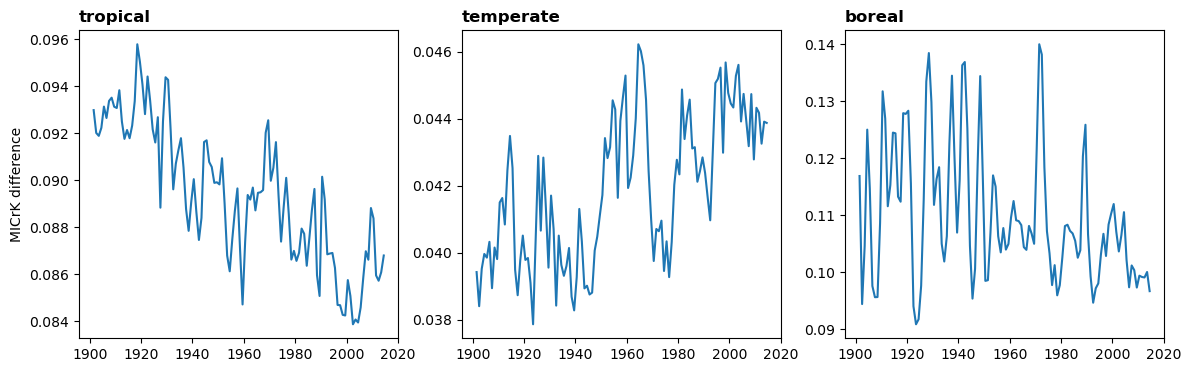

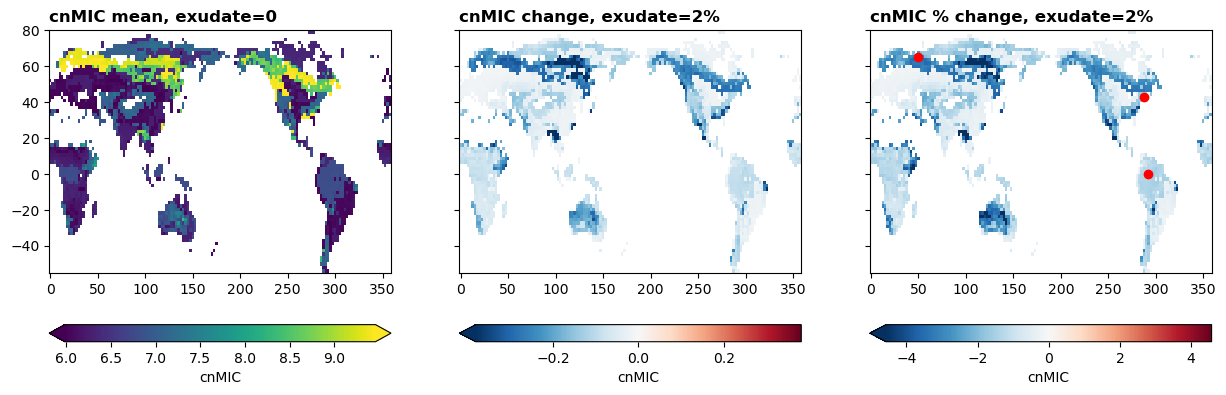

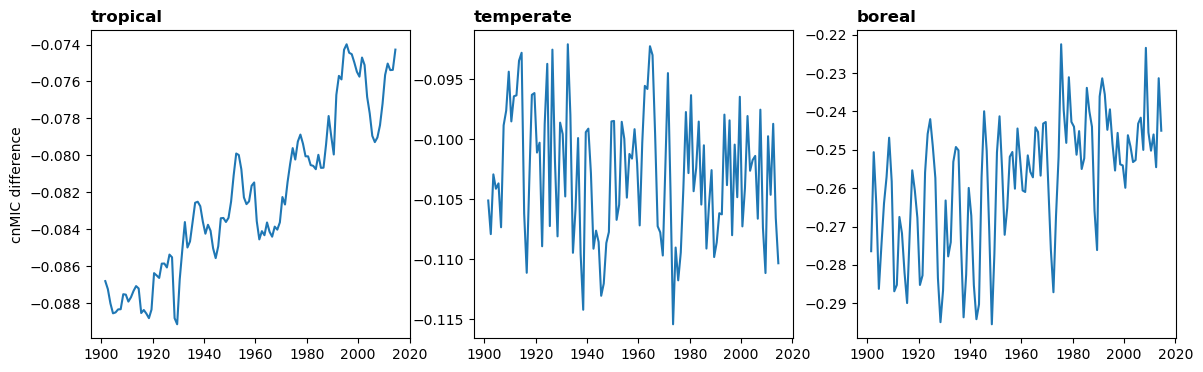

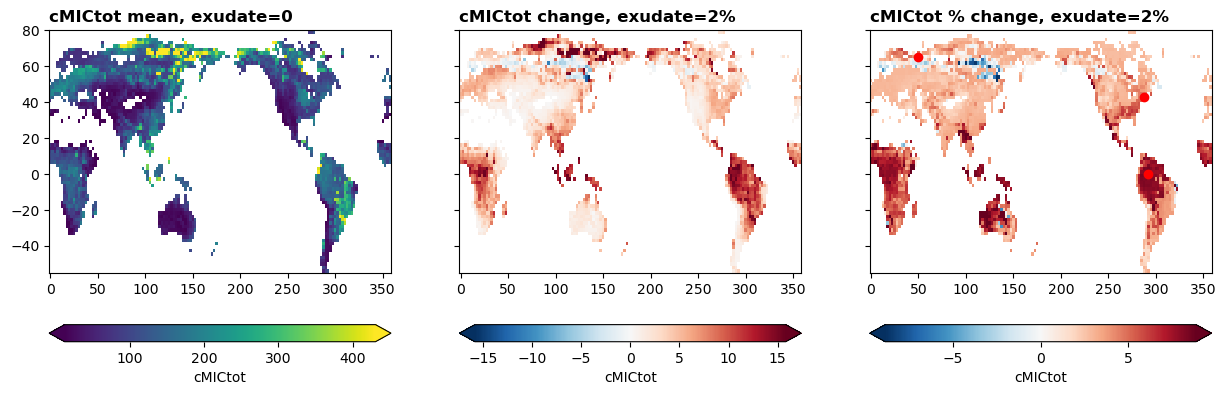

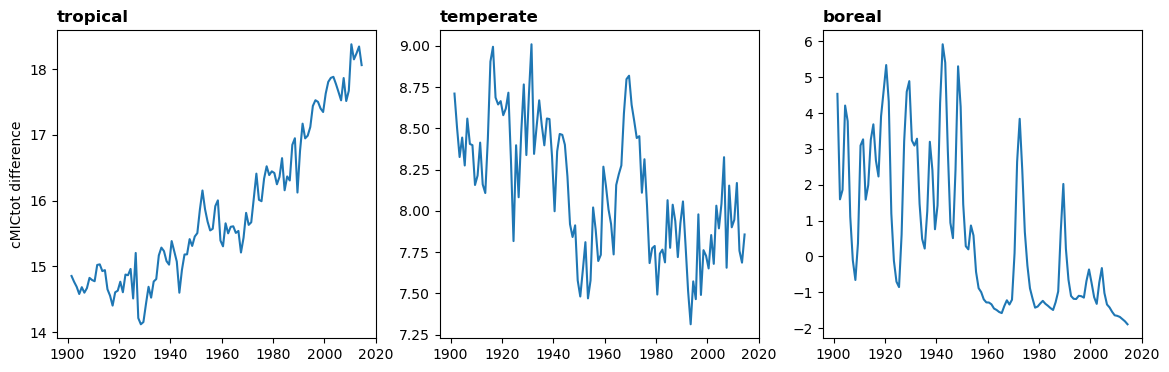

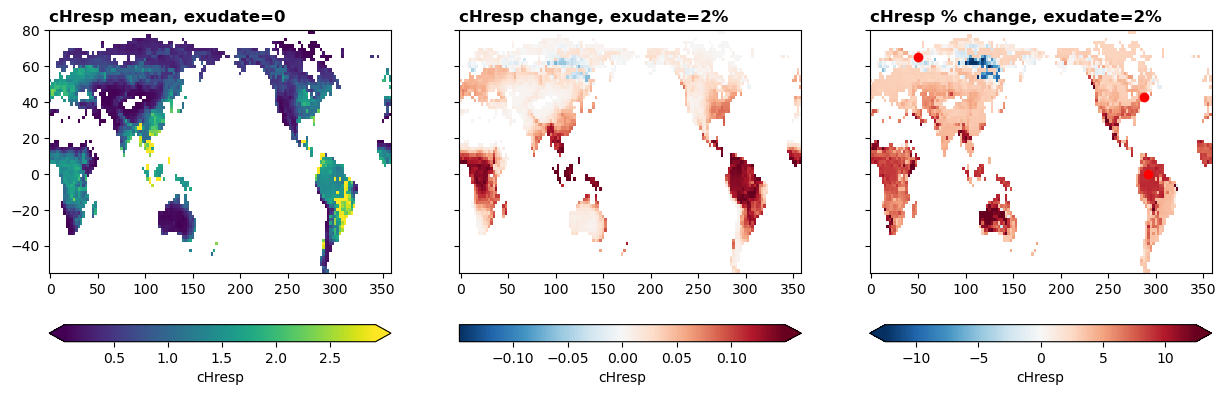

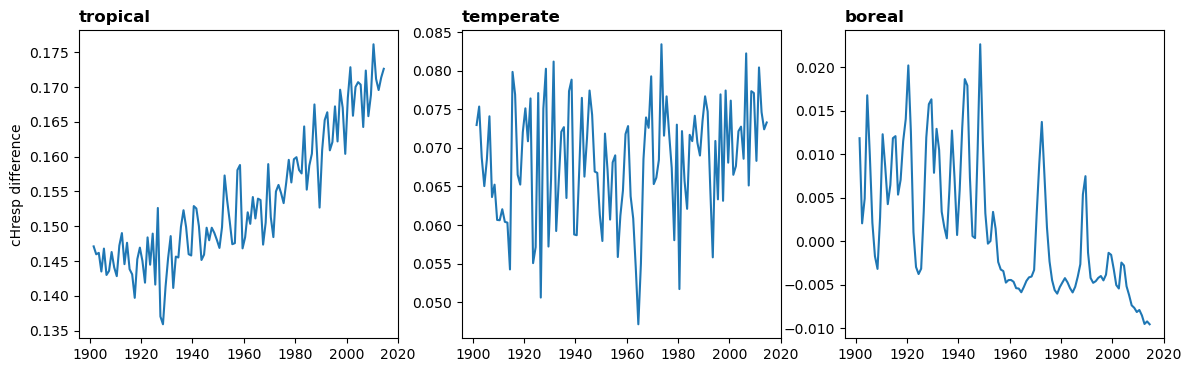

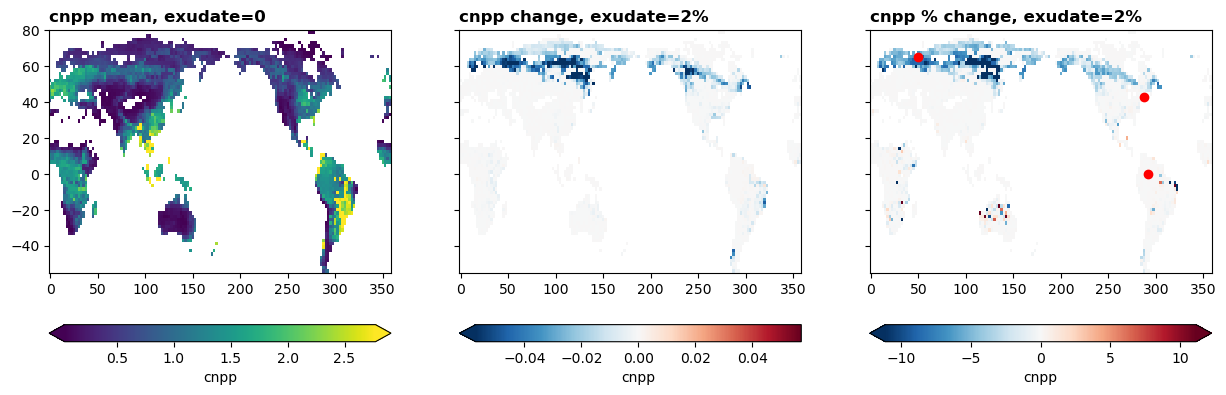

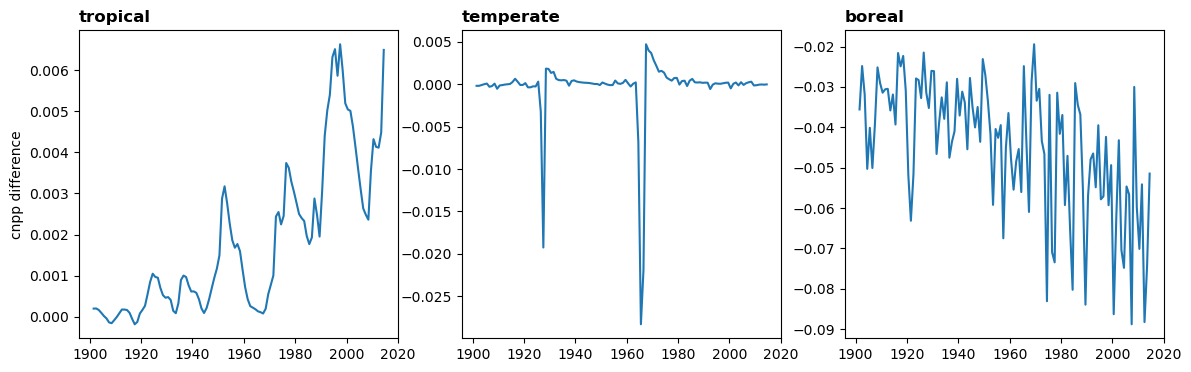

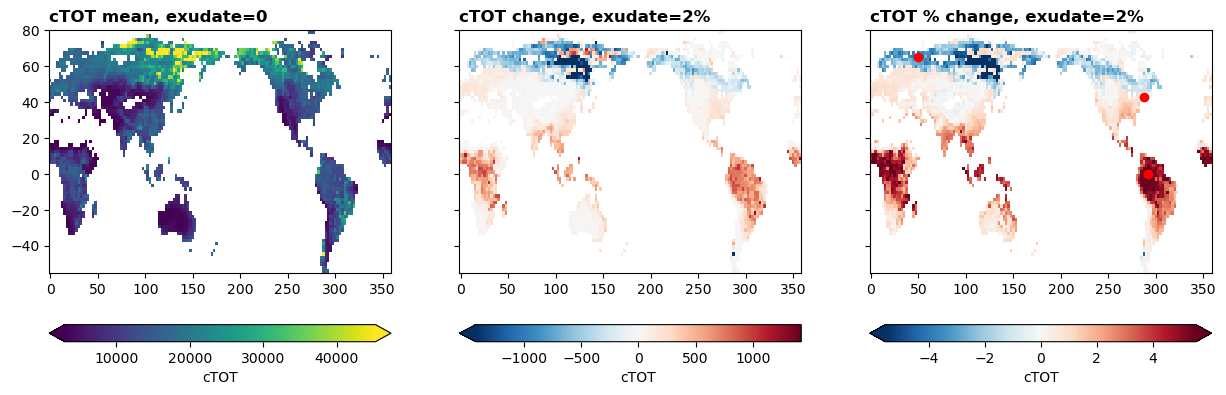

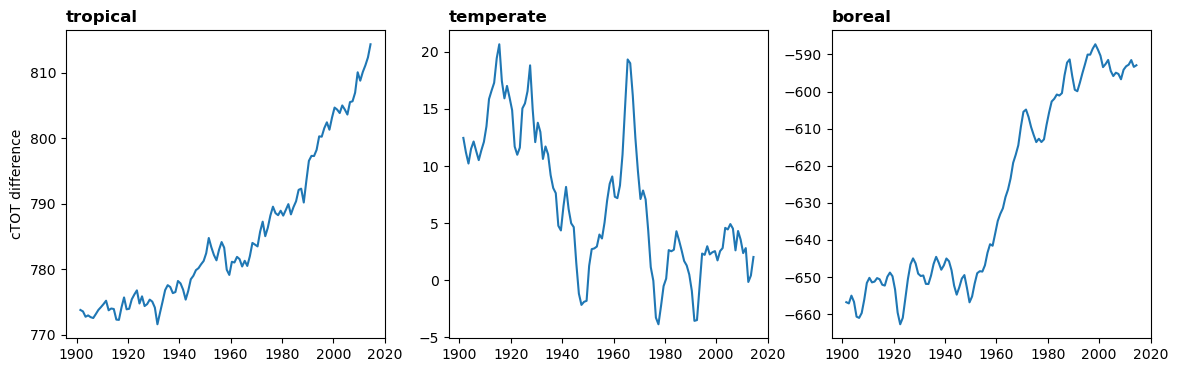

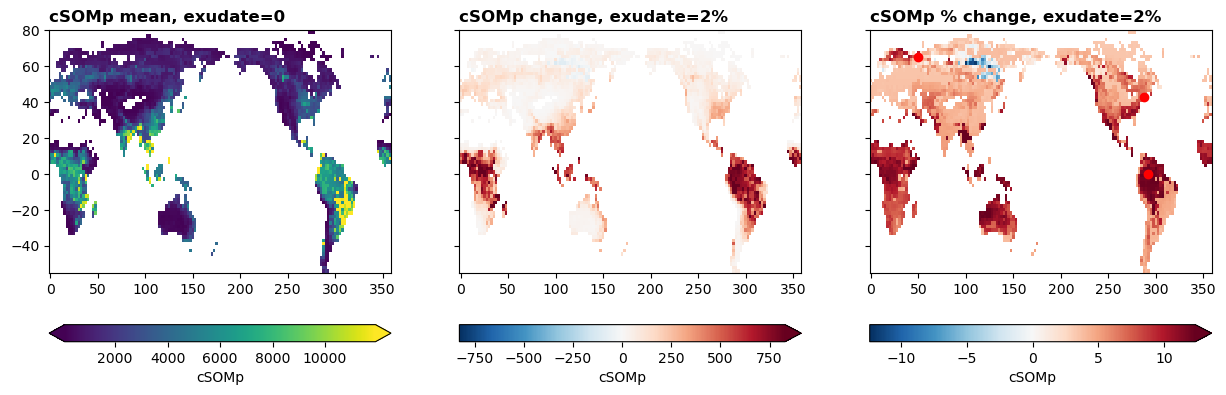

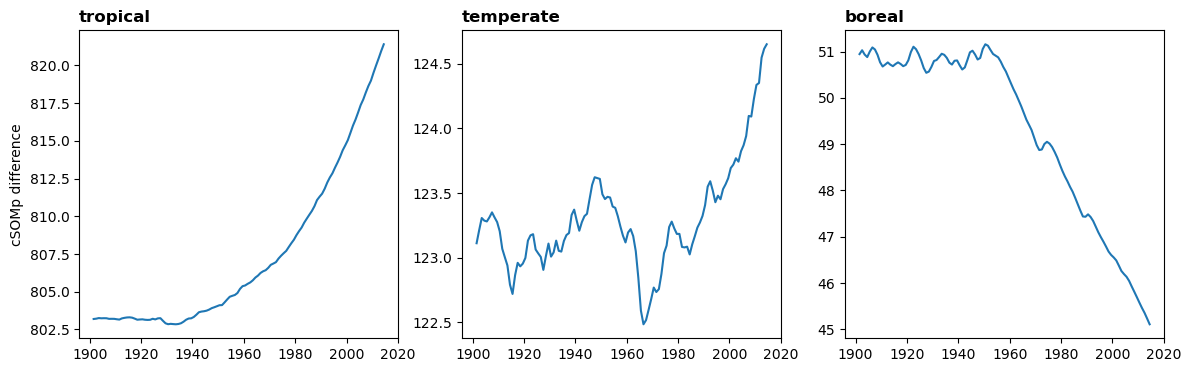

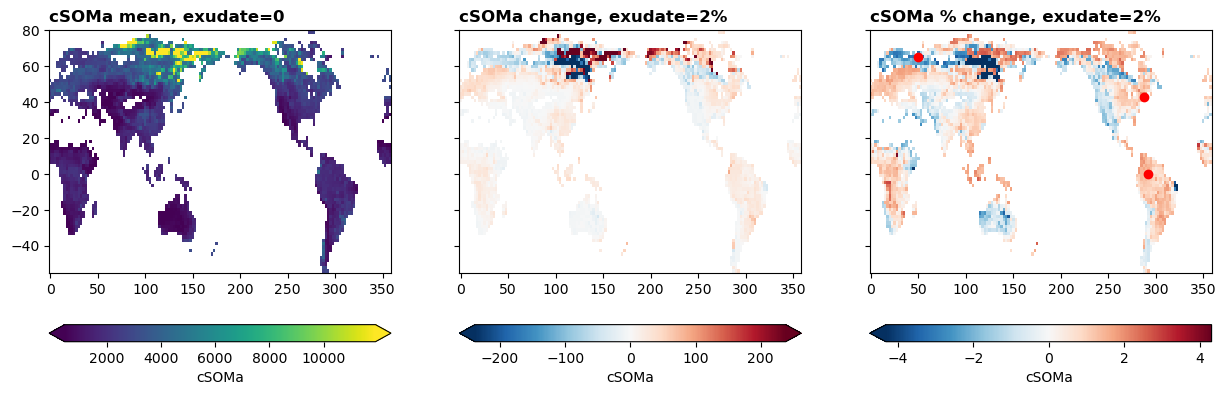

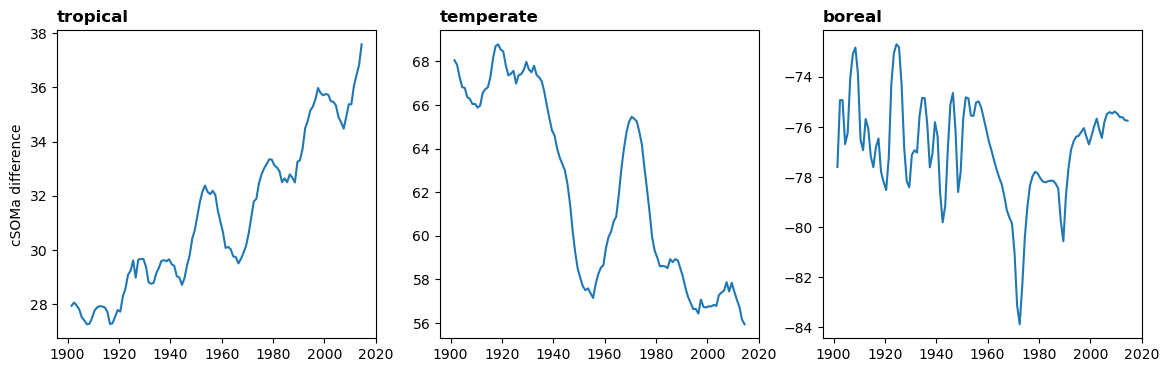

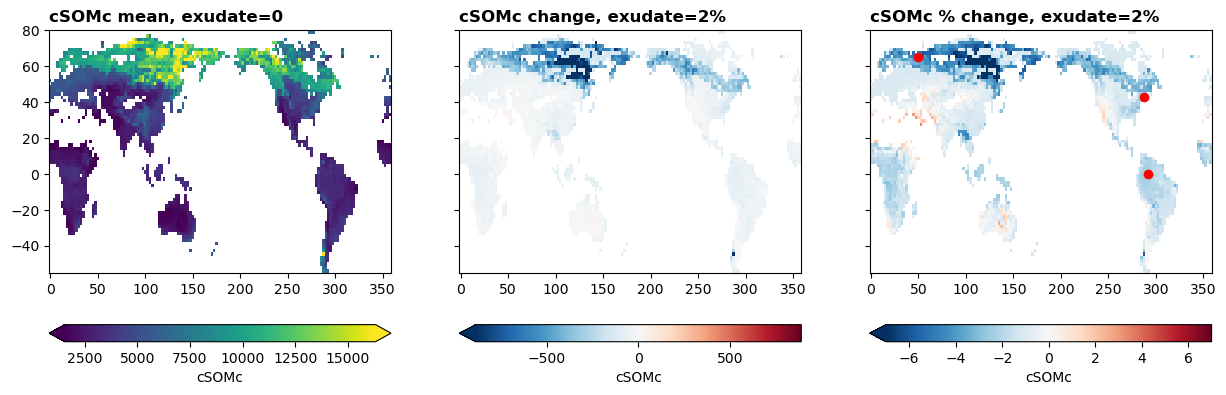

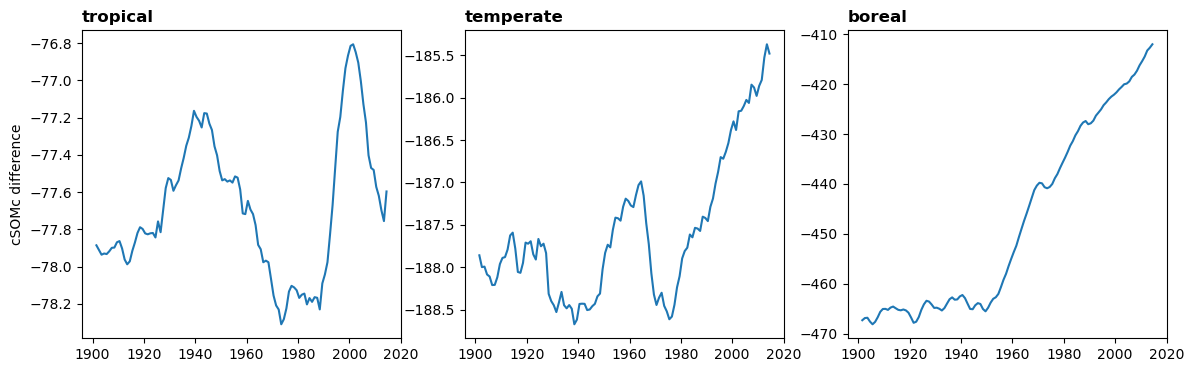

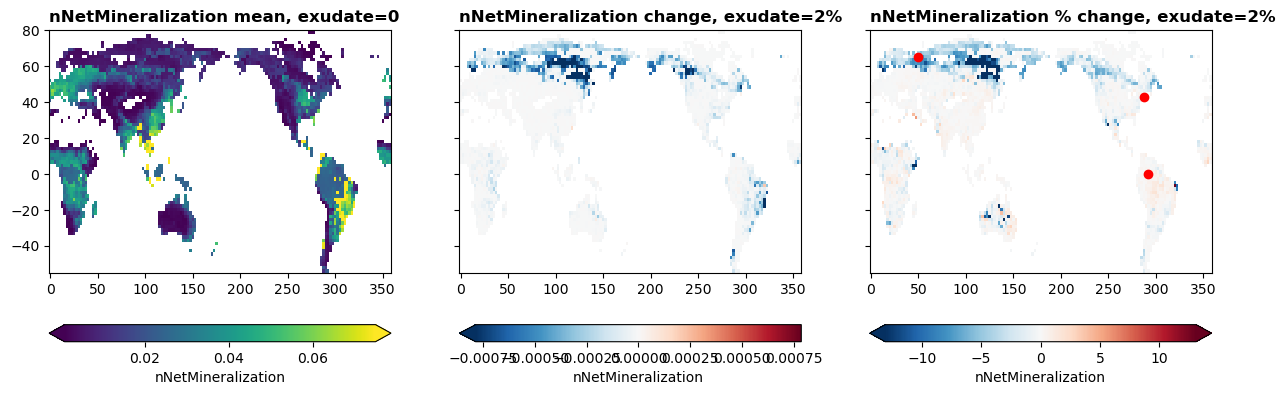

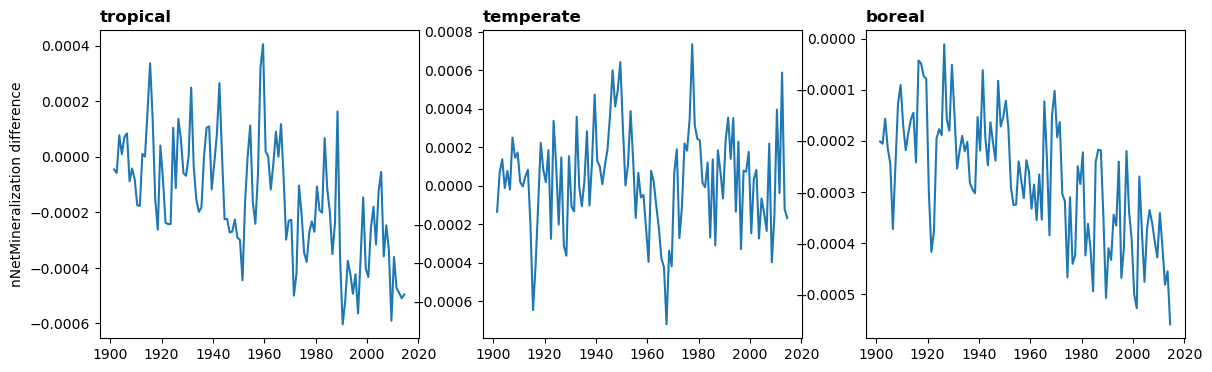

In [46]:
#quick look at differences
VAR = ['cnTOT','MICrK','cnMIC','cMICtot','cHresp','cnpp',
       'cTOT','cSOMp','cSOMa','cSOMc','nNetMineralization']

for v in range(len(VAR)):
    var=VAR[v]
    fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True,figsize=[15,4.5])
    # mean state
    plt.subplot(131)
    ds[var].isel(time=slice(0,5)).mean('time').plot(
        robust=True,cbar_kwargs={'location': "bottom"})
    plt.xlabel(None)
    plt.ylabel(None)
    plt.ylim(-55,80)
    plt.title(var+" mean, exudate=0",loc='left',fontweight='bold')

    # absolute change
    plt.subplot(132)
    (ds2[var] - ds[var]).isel(time=slice(0,20)).mean('time').plot(
        robust=True, center=0,cbar_kwargs={'location': "bottom"})
    plt.xlabel(None)
    plt.ylabel(None)
    plt.title(var+" change, exudate=2%",loc='left',fontweight='bold')
    plt.ylim(-55,80)

    # % change
    plt.subplot(133)
    (100*(ds2[var] - ds[var])/ds[var]).isel(time=slice(0,5)).mean('time').plot(
        robust=True, center=0,cbar_kwargs={'location': "bottom"})
    plt.xlabel(None)
    plt.ylabel(None) ;
    plt.title(var+ " % change, exudate=2%",loc='left',fontweight='bold') ;
    plt.ylim(-55,80)

    biome = ['tropical', 'temperate', 'boreal']
    lat = [0,42.5,65]
    lon = [292,(360-72.2),50]
    for i in range(3):
        plt.plot(lon[i],lat[i],'o',color='red')

    # Change over time for grid
    fig, axes = plt.subplots(nrows=1, ncols=3,figsize=[14,4],sharey=False)
    ax = plt.gca()
    for i in range(3):
        plt.subplot(1,3,(i+1))
        y = (ds2[var] - ds[var]).sel(lat=lat[i],lon=lon[i],method='nearest')
        plt.plot(y.time,y)
        plt.title(biome[i],loc='left',fontweight='bold') ;
        if i == 0:
            plt.ylabel(var+" difference")

